<a href="https://colab.research.google.com/github/nassanea/ML2021/blob/main/SHARE_MLSpring2021_HW2_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Homework 2-1 Phoneme Classification**

* Slides: https://speech.ee.ntu.edu.tw/~hylee/ml/ml2021-course-data/hw/HW02/HW02.pdf
* Video (Chinese): https://youtu.be/PdjXnQbu2zo
* Video (English): https://youtu.be/ESRr-VCykBs


## The DARPA TIMIT Acoustic-Phonetic Continuous Speech Corpus (TIMIT)
The TIMIT corpus of reading speech has been designed to provide speech data for the acquisition of acoustic-phonetic knowledge and for the development and evaluation of automatic speech recognition systems.

This homework is a multiclass classification task,
we are going to train a deep neural network classifier to predict the phonemes for each frame from the speech corpus TIMIT.

link: https://academictorrents.com/details/34e2b78745138186976cbc27939b1b34d18bd5b3

## Download Data
Download data from google drive, then unzip it.

You should have `timit_11/train_11.npy`, `timit_11/train_label_11.npy`, and `timit_11/test_11.npy` after running this block.<br><br>
`timit_11/`
- `train_11.npy`: training data<br>
- `train_label_11.npy`: training label<br>
- `test_11.npy`:  testing data<br><br>

**notes: if the google drive link is dead, you can download the data directly from Kaggle and upload it to the workspace**




In [ ]:
# gdown ：從 google drive 下載檔案
# --output data.zip ：把下載的檔案存為「data.zip」
!gdown --id '1HPkcmQmFGu-3OknddKIa5dNDsR05lIQR' --output data.zip
# 解壓縮 data.zip
!unzip data.zip
# 列出資料夾內容
!ls

/usr/local/lib/python3.11/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1HPkcmQmFGu-3OknddKIa5dNDsR05lIQR
From (redirected): https://drive.google.com/uc?id=1HPkcmQmFGu-3OknddKIa5dNDsR05lIQR&confirm=t&uuid=1a103917-7384-4985-beca-238f5d6a49ff
To: /content/data.zip
100% 372M/372M [00:06<00:00, 60.9MB/s]
Archive:  data.zip
   creating: timit_11/
  inflating: timit_11/train_11.npy   
  inflating: timit_11/test_11.npy    
  inflating: timit_11/train_label_11.npy  
data.zip  sample_data  timit_11


## Preparing Data
Load the training and testing data from the `.npy` file (NumPy array).

In [ ]:
import numpy as np

print('Loading data ...')

data_root='./timit_11/' # 設定資料夾路徑
# np.load() 是用來讀取資料的函數，讀取 .npy / .npz 的檔案，並還原成 NumPy 陣列格式，此函數的參數是「檔案路徑」
# 故「data_root + 'train_11.npy'」就是訓練資料的檔案路徑
# 下方訓練資料的label 以及測試資料也是如此
train = np.load(data_root + 'train_11.npy')
train_label = np.load(data_root + 'train_label_11.npy')
test = np.load(data_root + 'test_11.npy')


# 助教寫法，用 format()印出
# print('Size of training data: {}'.format(train.shape)) # 表示訓練資料有 1229932 筆，429 個欄位（1229932 x 429 的表格）
# print('Size of testing data: {}'.format(test.shape)) # 測試資料有 451552 筆，429 個欄位

# 改用 f-string 印出
print(f"Size of training data: {train.shape}") # 表示訓練資料有 1229932 筆，429 個欄位（1229932 x 429 的表格）
print(f"Size of testing data: {test.shape}") # 測試資料有 451552 筆，429 個欄位

Loading data ...
Size of training data: (1229932, 429)
Size of testing data: (451552, 429)


## Create Dataset

用 PyTorch 建立自訂的 Dataset 類別，以便用 DataLoader 載入資料

In [ ]:
import torch
# torch.utils.data 是 PyTorch 裡專門處理資料載入和管理的工具包
# 主要功能包含：
# 1. Dataset：定義資料集格式，方便統一接口取得資料和標籤。（torch.utils.data.Dataset 是一個抽象類別，沒有定義屬性）
# 2. DataLoader：搭配 Dataset 使用，實現資料批次載入、隨機打散（shuffle）、多線程讀取等功能。
# 3. Sampler：控制資料的取樣順序，比如隨機或序列取樣。
from torch.utils.data import Dataset


# 定義 TIMITDataset 類別，並繼承自 Dataset
class TIMITDataset(Dataset):
    # 定義建構子，X 是輸入資料（特徵矩陣），y 是標籤，預設可不給（None）
    # 作用：讓資料可以是有標籤的訓練集或沒標籤的測試集
    def __init__(self, X, y=None): # 補：self 是 TIMITDataset 這個物件本身
        # 把輸入資料 X 存入 此 TIMITDataset 物件的 data 屬性中
        # 存入前會先轉換成 Tensor 型態並且轉成 float 型態
        # torch.from_numpy() 是把 NumPy 資料轉成 PyTorch 能接受的 Tensor
        self.data = torch.from_numpy(X).float()
        if y is not None: # 訓練階段
            # .astpye() 是 NumPy 提供的型態轉換方法
            # 先把 y 轉換成 int64 型態以確保資料型態一致
            y = y.astype(np.int64) # 根據版本更新把 np.int 改為 np.int64
            # 再把 y 轉換成 Tensor 格式，然後 assign 給 此 TIMITDataset 物件的 label 屬性中
            # torch.LongTensor() 一律轉成 torch.int64 （即 LongTensor）型態
            self.label = torch.LongTensor(y)
        else: # 測試階段
            self.label = None

    # 繼承 Dataset 後，必須實作的方法
    # 會透過此方法一筆筆取出資料
    def __getitem__(self, idx):
        if self.label is not None: # 訓練階段（有標籤）
            # 回傳資料是第 idx 筆＆其對應的標籤
            return self.data[idx], self.label[idx]
        else:
            return self.data[idx]

    # 繼承 Dataset 後，必須實作的方法
    # DataLoader 在切 batch 時會用到此方法
    def __len__(self):
        # 回傳資料筆數
        return len(self.data)


Split the labeled data into a training set and a validation set, you can modify the variable `VAL_RATIO` to change the ratio of validation data.

把訓練資料切分成訓練資料集＆驗證資料集

In [ ]:
# 驗證資料集的比例
VAL_RATIO = 0.2 # 可以做修改比例

# 複習：shape() 會回傳 tuple，即（行數x列數）的資料
# 所以 shape[0] 就是行數，可以理解為資料的筆數；shape[1] 就是列數（欄位數；特徵數）
percent = int(train.shape[0] * (1 - VAL_RATIO)) # 即 訓練資料總筆數 x 0.8 ，再轉換成 int 型態

# 同時 assign 多個變數
# 切片語法：常用於取出部分資料
# train[:percent] 指的是 -> 取出第 0 筆到第 percent-1 筆（前 N 筆資料）
# train[percent:] 指的是 -> 從第 percent 筆到最後（後 N 筆資料）
# 所以下面是在切分訓練資料和驗證資料
train_x, train_y, val_x, val_y = train[:percent], train_label[:percent], train[percent:], train_label[percent:]

# 實際印出訓練資料和驗證資料的資料筆數
print(f'Size of training set: {train_x.shape}')
print(f'Size of validation set: {val_x.shape}')

Size of training set: (983945, 429)
Size of validation set: (245987, 429)


Create a data loader from the dataset, feel free to tweak the variable `BATCH_SIZE` here.

In [ ]:
# 設定每次訓練資料的筆數，每次看一個 batch 的量
BATCH_SIZE = 32

# 引入 DataLoarder，搭配 Dataset 使用，實現資料批次載入、隨機打散（shuffle）、多線程讀取等功能。
# 剛剛的 create Dataset 就是 DataLoader 的前置處理作業
from torch.utils.data import DataLoader

# new 一個 TIMITDataset 物件出來，傳入訓練資料以及其對應的訓練資料標籤，並 assign 給 訓練集
# 如此就擁有一個可以透過 __getitem__() 按 index 取出 (x, y) 的資料集
train_set = TIMITDataset(train_x, train_y)
# new 一個 TIMITDataset 物件出來，傳入驗證資料以及其對應的驗證資料標籤，並 assign 給 驗證集
val_set = TIMITDataset(val_x, val_y)


# 理解 DataLoader：DataLoader 是工廠生產線
# 按照你的設定（batch size、shuffle、num_workers）去批量生產資料「包裹（batch）」，一次交給模型。
# 按照設定好的 batch size 切分資料，製作成 DataLoader 以便後續訓練
# train_loader 會設定每個 epoch 都打亂一次資料
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True) #only shuffle the training data
# 通常驗證資料不會打亂資料，如同測試階段不會打亂資料一樣，是避免增加複雜度
# 驗證不需要隨機性，只要固定測效果
val_loader = DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=False)

Cleanup the unneeded variables to save memory.<br>

**notes: if you need to use these variables later, then you may remove this block or clean up unneeded variables later<br>the data size is quite huge, so be aware of memory usage in colab**

In [ ]:
import gc # gc: garbage collector -> 清除用不到的變數

# 刪除變數引用，因為所需要用於訓練和驗證的資料都存在 train_loader & val_loader 裡面
# 不需要再用到這些變數了，可以清除
del train, train_label, train_x, train_y, val_x, val_y
# 強制執行垃圾回收
# 剛剛 del 掉的資料中，如果沒有其他地方還在引用，就會真的從記憶體中移除
gc.collect()

30

## Create Model

Define model architecture, you are encouraged to change and experiment with the model architecture.

In [ ]:
import torch
import torch.nn as nn # torch.nn 是 PyTorch 中負責定義神經網路層和結構的模組

# 定義 Classifier 類別，繼承 nn.Model （通常都會繼承）
# 因為 nn.Module 是 PyTorch 中所有模型的基底類別（base class），其提供很多底層必要功能（否則就要自己實作）
class Classifier(nn.Module):
    # 定義建構子，用於初始化 model 的 layer 和參數
    def __init__(self):
        # 呼叫父類別建構子
        super(Classifier, self).__init__()
        # 開始定義模型：四層 FC (Linear Layers 就是 Fully Connected) 每一個輸入節點都連接到每一個輸出節點
        # nn.Linear(in_features, out_features)，network 會學一個 in(x) × out(y) 的權重矩陣，還有一個偏差向量（bias）
        # 疊幾層、維度多少也是一個超參數了，常見設計原則是維度逐漸減少
        # self.layer1 = nn.Linear(429, 1024) # 輸入 429 維度；輸出 1024 維度
        # self.layer2 = nn.Linear(1024, 512) # 輸入 1024 維度；輸出(降維)成 512 維度
        # 調整維度，降低模型複雜度
        self.layer1 = nn.Linear(429, 512)
        self.layer2 = nn.Linear(512, 256)
        self.layer3 = nn.Linear(256, 128)
        self.layer4 = nn.Linear(128, 64)  # 新增

        # 最終輸出 39 維度，代表 39 個類別（到最後就是分類分39類，0~38），這是任務決定的輸出維度
        # Classifier 類別定義了 .out 屬性（輸出層 out_layer）
        self.out = nn.Linear(64, 39)

        # 定義激勵函數(activation function)，並使用 Sigmoid 當激勵函數，換轉換輸出資料成0~1之間
        self.act_fn = nn.ReLU()

        # 設定 Drouput ，通常放在激勵函數後
        self.dropout = nn.Dropout(0.2) # 30% 的神經元會被隨機關閉

        # 加入 BatchNorm
        self.bn1 = nn.BatchNorm1d(512) # 要對應 layer1 的輸出維度
        self.bn2 = nn.BatchNorm1d(256)
        self.bn3 = nn.BatchNorm1d(128)
        self.bn4 = nn.BatchNorm1d(64)

    # 繼承 nn.Module 所以一定要實作 forward() 方法
    # 定義輸入資料要怎麼經過層層處理，最後得到輸出
    # => 實際上是由 forward 裡面的順序實際定義 輸入資料x 是以怎麼樣的順序通過 model 的（上面的 __init__() 並不會決定 model 的疊加順序，而是 forward 決定）
    # __init__() 是用來「定義好會用到的層」，就像建好材料。
    # forward() 是用來「決定這些層怎麼接起來用、用的順序是什麼」，就像建好流程圖
    # 此處定義輸入資料 x 會經過每一層 FC 後，都通過一次 Sigmoid
    def forward(self, x):
        # Linear → BatchNorm → ReLU → Dropout
        x = self.layer1(x)
        x = self.bn1(x)
        x = self.act_fn(x)
        x = self.dropout(x)

        x = self.layer2(x)
        x = self.bn2(x)
        x = self.act_fn(x)
        x = self.dropout(x)

        x = self.layer3(x)
        x = self.bn3(x)
        x = self.act_fn(x)
        x = self.dropout(x)

        # 新增的 layer4
        x = self.layer4(x)
        x = self.bn4(x)
        x = self.act_fn(x)
        x = self.dropout(x)


        # 最後一個輸出層不套激勵函數，是因為分類任務通常使用 CrossEntropy 計算 Loss，這時會自動做 softmax，所以不用再加激勵函數
        x = self.out(x)
        return x

## Training

In [ ]:
#check device 檢查運算裝置
# 定義方法來檢查運算裝置
def get_device():
  # 語法是三元運算子
  # torch.cuda.is_available() 是 PyTorch 提供的方法，檢查目前環境是否可以使用 NVIDIA 的 GPU（還有其他方法）
  return 'cuda' if torch.cuda.is_available() else 'cpu'

Fix random seeds for reproducibility.

目的是為訓練過程的隨機固定性

In [ ]:
# fix random seed
# 隨機種子的作用是固定模型訓練過程中所產生的隨機數，從而在對所描述模型進行複現的時候可以最大程度地逼近描述效果。
# reference: https://zhuanlan.zhihu.com/p/545344518
def same_seeds(seed): # 此 Seed 是要設定的隨機種子，用以控制所有隨機過程的起始點
    # torch.manual_seed() 用於設定 PyTorch 設定 CPU 的隨機數生成器的種子值
    torch.manual_seed(seed)
    # 如果使用 GPU，也要設定 GPU 的隨機種子
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed) # 針對單張 GPU
        torch.cuda.manual_seed_all(seed) # 針對多張 GPU，設定所有可見 GPU 上的種子
    # 固定 NumPy 的隨機種子
    np.random.seed(seed)
    # 關閉 cuDNN 的 benchmark 模式
    # cuDNN 是 NVIDIA 提供的深度學習加速函式庫，它的 benchmark 模式會根據輸入自動尋找最快的算法，但這樣會引入隨機性。
    # 所以，關掉它可以讓你得到一致的結果
    torch.backends.cudnn.benchmark = False
    # 啟用 cuDNN 的「確定性模式」。
    # 意思是：只使用會產生固定輸出的演算法，讓模型每次執行結果都一樣。
    torch.backends.cudnn.deterministic = True

Feel free to change the training parameters here.

In [ ]:
# fix random seed for reproducibility
# 使用剛剛定義的設定隨機種子方法
same_seeds(0)

# get device，呼叫檢查運算裝置的方法
device = get_device()
print(f'DEVICE: {device}')

# training parameters 設定訓練的超參數
num_epoch = 23               # number of training epoch（完整看過一次訓練稱為一個 epoch）
learning_rate = 0.0001       # learning rate（參數的更新幅度）

# the path where checkpoint saved 設定路徑儲存訓練好的模型
model_path = './model.ckpt'

# create model, define a loss function, and optimizer
# new 出一個剛剛定義的 Classifier 物件
# 並呼叫 .to(device)，把資料/模型移動到指定的運算裝置上
model = Classifier().to(device)
# 定義 loss function，使用 CrossEntropyLoss
# CrossEntropyLoss 是 PyTorch 提供的 class ，是 nn.Module 的子類別，所以此行是在 new 一個 CrossEntropyLoss 物件（實例化損失函數）
criterion = nn.CrossEntropyLoss()
# 定義最佳化器（找到讓 loss 最小的參數組合），使用 Adam
# model.parameters() 表示要優化的是模型中的所有參數。
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay = 1e-5)

DEVICE: cuda


In [ ]:
# start training

# 紀錄 train_loss, val_loss 以便繪圖觀察
train_loss_list = []
val_loss_list = []

# 初始化 best_acc，用於記錄目前為止驗證集上最高的 acc，以便選出最好的模型
best_acc = 0.0
# 訓練的主要 loop，共跑 epoch 次（所有訓練資料被完整看過 epoch 次）
for epoch in range(num_epoch):
    # 初始化每個 epoch 的訓練/驗證 acc & loss
    train_acc = 0.0
    train_loss = 0.0
    val_acc = 0.0
    val_loss = 0.0

    # training
    # .train() 是 nn.Module 提供的方法，能夠把 model 設為「訓練模式」，即會啟用 Dropout、Batch Normalization
    # .train() 不是指開始訓練，而是切換狀態，表示該開啟 dropout 等等的準備工作
    model.train() # set the model to training mode
    # enumerate 會 走訪 train_loader，並 return (i, data)
    # 透過 train_loader 一批批的取出訓練資料，一次取出一個 batch size 的量
    for i, data in enumerate(train_loader):
        # 解包出輸入與標籤，並將它們搬到 GPU 上
        inputs, labels = data # data 包含 x & y
        inputs, labels = inputs.to(device), labels.to(device)
        # 清除前一次 backward 計算累積的梯度
        optimizer.zero_grad()
        # 把 input 喂給 model，並 assign 結果給 output 變數
        # 這一行表面這樣的運行，但背後 PyTorch 實際執行的是：outputs = model.__call__(inputs)
        # 因為 nn.Module 有內建一個 __call__() 方法，裡面定義了會去呼叫 forward() 函數的指令，故會正常 return output
        outputs = model(inputs)
        # 計算 loss
        # CrossEntropyLoss 類別中有定義 __call__() 方法，會去呼叫 forward 來計算 loss，故可以於此處傳入參數
        batch_loss = criterion(outputs, labels)
        # torch.max(tensor, dim) 會在指定的 tensor 的指定的 dim 上找最大值，
        # 若 dim=0，會是比較同一欄位（直的看），不常用於分類任務；若 dim=1，會是比較同一列（每個樣本的類別分數，橫的看），這才叫常用於分類任務
        # 並 return 一個 tuple，包含(1)該 dim 維度上最大值的數值；(2)最大值的位置（index）
        # 並把這個 tuple 含有的兩個值 assign 給 _ & train_pred，但因為我只在乎最大值的索引，也就是(2) ，因為(2)預測出的分類label是哪個，index 才是我想知道的分類結果
        # 所以用「_」這個語法表示「我知道這裡有個值，但我不在意、不會用它。」，以此忽略(1)的最大值
        # 如此 train_pred 裡面便是預測結果
        _, train_pred = torch.max(outputs, 1) # get the index of the class with the highest probability
        # 進行反向傳播 Backpropagation，計算每個參數的梯度
        batch_loss.backward()
        # 使用最佳化器更新參數
        optimizer.step()
        # 統計「預測正確的樣本數」，並加總到變數 train_acc 中（通常最後會除以總數得到準確率）。
        # 要先把 train_pred 和 labels 移回 CPU 才能做後續運算
        # train_pred.cpu() == labels.cpu() 會回傳一個布林 tensor，表示每一個預測是否正確
        # .sum() 是把布林 tensor 轉為數字後相加，所以會是「預測正確的個數」
        # .item() 把只有一個值的 tensor（剛剛加總的sum（）的結果）轉為 int 型態
        # 在累加到 train_acc 中，計算預測總正確數量
        train_acc += (train_pred.cpu() == labels.cpu()).sum().item()
        # 累加每個 batch 的 loss，batch_loss 也是只有一個值的 tensor
        train_loss += batch_loss.item()

    # validation
    if len(val_set) > 0: # 如果驗證集不為空就：
        # 設為評估模式，會停用 dropout 和 batchnorm 的隨機行為
        model.eval() # set the model to evaluation mode
        # 驗證階段不用計算梯度
        with torch.no_grad():
            for i, data in enumerate(val_loader):
                inputs, labels = data
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                batch_loss = criterion(outputs, labels)
                # 取得預測類別
                _, val_pred = torch.max(outputs, 1)

                # 計算這 batch 的正確預測數，並加總進 val_acc
                val_acc += (val_pred.cpu() == labels.cpu()).sum().item() # get the index of the class with the highest probability
                val_loss += batch_loss.item()

            # 印出訓練過程中某一個 epoch 的結果摘要（印出每一進度的狀況）
            # 在每個 epoch 結束時，向使用者顯示訓練與驗證的準確率與損失，方便監控模型訓練狀況。
            #print('[{:03d}/{:03d}] Train Acc: {:3.6f} Loss: {:3.6f} | Val Acc: {:3.6f} loss: {:3.6f}'.format(
            #    epoch + 1, num_epoch, train_acc/len(train_set), train_loss/len(train_loader), val_acc/len(val_set), val_loss/len(val_loader)
            #))
            # f-string 版本
            print(f"[{epoch + 1:03d}/{num_epoch:03d}] "
                  f"Train Acc: {(train_acc / len(train_set)):.6f} "
                  f"Loss: {(train_loss / len(train_loader)):.6f} | "
                  f"Val Acc: {(val_acc / len(val_set)):.6f} "
                  f"loss: {(val_loss / len(val_loader)):.6f}" )

            ##### 自己加的，用來繪製 loss 變化趨勢用
            # 把每次 epoch 算出的 loss 紀錄到 list 中
            train_loss_list.append(train_loss / len(train_loader))
            if len(val_set) > 0:
              val_loss_list.append(val_loss / len(val_loader))
            #####

            # if the model improves, save a checkpoint at this epoch
            # 如果目前驗證準確率，比歷史最高還好，那就更新 best_acc
            if val_acc > best_acc:
                best_acc = val_acc
                # 儲存模型的參數
                # model.state_dict() 可以獲取 model 的參數，接下來用 torch.save() 儲存
                # model_path 是儲存 model 參數的路徑
                torch.save(model.state_dict(), model_path)
                print('saving model with acc {:.3f}'.format(best_acc/len(val_set)))

    # 若沒有驗證集（調完參數後，最後一次把所有資料全部都給訓練階段時）
    else:
        print('[{:03d}/{:03d}] Train Acc: {:3.6f} Loss: {:3.6f}'.format(
            epoch + 1, num_epoch, train_acc/len(train_set), train_loss/len(train_loader)
        ))

# if not validating, save the last epoch
# 如果沒有驗證階段，在最後一個 epoch 儲存模型
if len(val_set) == 0:
    torch.save(model.state_dict(), model_path)
    print('saving model at last epoch')


[001/023] Train Acc: 0.506187 Loss: 1.700141 | Val Acc: 0.644981 loss: 1.169572
saving model with acc 0.645
[002/023] Train Acc: 0.571189 Loss: 1.426597 | Val Acc: 0.669702 loss: 1.069938
saving model with acc 0.670
[003/023] Train Acc: 0.590855 Loss: 1.352658 | Val Acc: 0.680113 loss: 1.027705
saving model with acc 0.680
[004/023] Train Acc: 0.602254 Loss: 1.308939 | Val Acc: 0.686971 loss: 1.000002
saving model with acc 0.687
[005/023] Train Acc: 0.611245 Loss: 1.276982 | Val Acc: 0.691939 loss: 0.980909
saving model with acc 0.692
[006/023] Train Acc: 0.616695 Loss: 1.254905 | Val Acc: 0.697061 loss: 0.961880
saving model with acc 0.697
[007/023] Train Acc: 0.622351 Loss: 1.236758 | Val Acc: 0.700704 loss: 0.943487
saving model with acc 0.701
[008/023] Train Acc: 0.626083 Loss: 1.223065 | Val Acc: 0.703301 loss: 0.934373
saving model with acc 0.703
[009/023] Train Acc: 0.629619 Loss: 1.210849 | Val Acc: 0.703932 loss: 0.934040
saving model with acc 0.704
[010/023] Train Acc: 0.63188

用 matplotlib 繪製 train_loss, val_loss 趨勢圖以便觀察

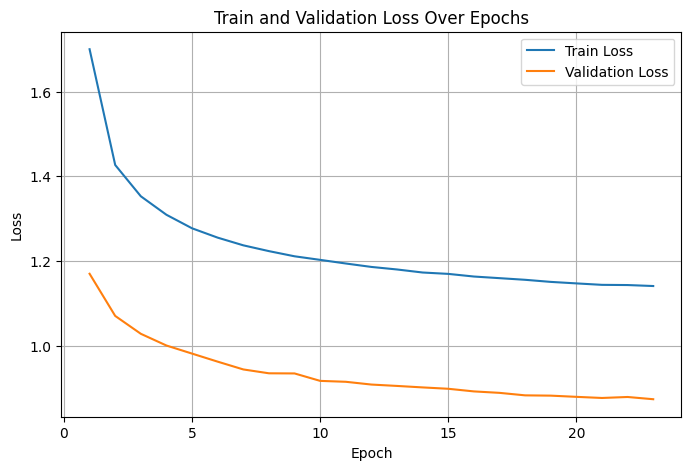

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.plot(range(1, num_epoch+1), train_loss_list, label='Train Loss')
if len(val_loss_list) > 0:
    plt.plot(range(1, num_epoch+1), val_loss_list, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train and Validation Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

## Testing

Create a testing dataset, and load model from the saved checkpoint.

In [ ]:
# create testing dataset
# 創建測試資料集，所以沒有標籤(y)
test_set = TIMITDataset(test, None)
test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False)

# create model and load weights from checkpoint
# new model 物件
model = Classifier().to(device)
# 載入剛剛訓練好的 model 參數
# torch.load(檔案路徑) 可以載入保存的資料，和 torch.save() 配對使用
# .load_state_dict(state_dict) 則用來把參數資料載入到 model，讓 model 獲得訓練的參數
model.load_state_dict(torch.load(model_path))

<All keys matched successfully>

Make prediction.

In [ ]:
predict = [] # 儲存測試階段預測結果
model.eval() # set the model to evaluation mode（模型在測試時的行為一致性）
# 在此 block 內停用梯度計算（節省記憶體和計算資源、測試階段不需要反向傳播，所以不需要梯度）
with torch.no_grad():
    # 遍歷測試資料(test_loader)
    for i, data in enumerate(test_loader):
        # 同樣解包測試資料並移動到 GPU 去
        inputs = data
        inputs = inputs.to(device)
        # 將輸入資料傳入模型進行前向傳播
        outputs = model(inputs)
        # 取得預測結果（同樣也只需要最大值的 index -> 即分類的類別標籤即可）
        _, test_pred = torch.max(outputs, 1) # get the index of the class with the highest probability

        # 儲存預測結果
        # 把測試結果移動到 cpu，再轉成 numpy 型態陣列（因為 NumPy 只支援 CPU tensor）
        for y in test_pred.cpu().numpy():
            # 逐項加入到 predict 中
            predict.append(y)

Write prediction to a CSV file.

After finish running this block, download the file `prediction.csv` from the files section on the left-hand side and submit it to Kaggle.

In [ ]:
# 使用 with 語句開啟檔案，確保檔案會被正確關閉（不用手動，所以不用寫 f.close()）
# 以「寫入模式 ('w')」打開一個名為 prediction.csv 的檔案
# 如果該檔案已存在，會清空內容重新寫入；若不存在，則會建立一個新檔案
with open('prediction.csv', 'w') as f: # 把檔案物件指派給 f 變數
    # 寫入 csv 檔案的 header，分別是Id, Class
    f.write('Id,Class\n')
    # 用 i 表示 index, y 表示預測結果 來遍歷剛剛得出的 testing 結果
    for i, y in enumerate(predict):
        # 使用寫入功能寫入遍歷的資料
        #  str.format() 方法格式化字串
        # {},{}：兩個佔位符，分別對應 i 和 y。並且每行結束後換行
        f.write('{},{}\n'.format(i, y))
        # 另外這行也可以不要用 format ，改用 f-string 的話如下所示
        # f.write(f"{i}, {y}\n")